# Trabajo Práctico 1 - Procesamiento Digital de Señales
Desarrollado por Martín Haimovich e Ignacio Veiga, UNTREF, Octubre de 2022. 

Se destaca la importancia de ejecutar las celdas del presente Notebook de forma secuencial, para asegurar su correcto funcionamiento.

Versión de Python utilizada para el desarrollo: 3.10.0

Para ciertas funcionalidades, como los gráficos hechos con la librería plotly, puede ser necesario actualizar la versión de nbformat (pip install --upgrade nbformat).

### Ejercicio 1

Se importan las bibliotecas necesarias

In [84]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig

Defino los parametros de frecuencia, frecuencia de muestreo, numero de armonicos, tiempo y la cantidad de muestras por 2 segundos.

In [85]:
f0 = 440
fs = 44100
K = 5
signalTime = 2

N = (signalTime*fs)//1

Defino un vector n cuyos elementos irán desde 0 hasta el numero de muestra que se encuentra en el segundo 2, genero el vector tiempo de 2 segundos y defino un vector A que esta lleno de ceros, cuya cantidad de elementos es igual a las muestras en 2 seg (N).

In [86]:
n = np.arange(N)
t = np.linspace(0,2,N)
A = np.zeros(N)

Voy agregandole elementos al vector A (armonicos) y grafico cada armonico. Finalmente, normalizo y grafico la señal completa.

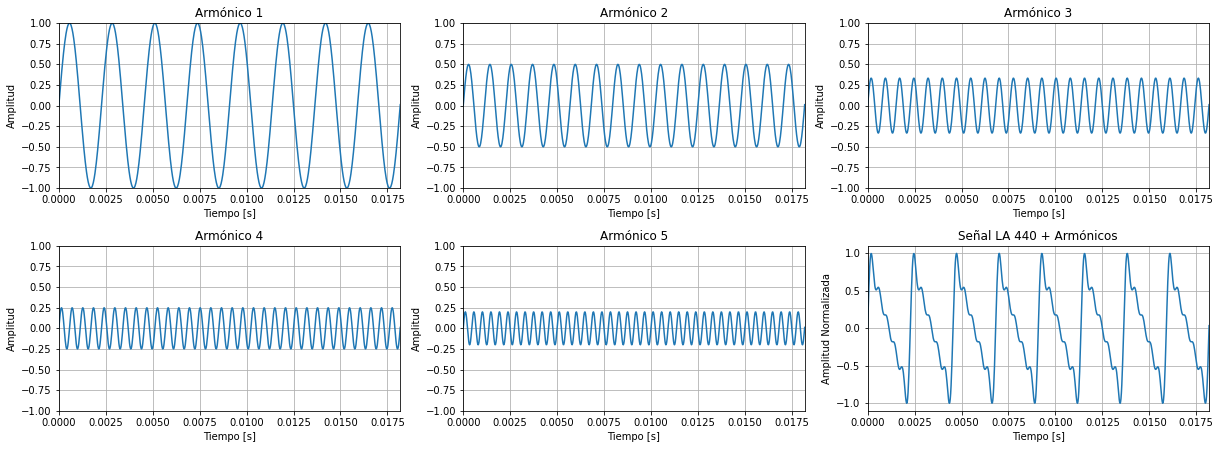

In [87]:
plt.figure(figsize=(17,9))
for k in range(1,K+1):
    armonicos = (1/k) * np.sin(2*n*k*np.pi*(f0/fs))
    A += armonicos
    plt.subplot(3,3,k)
    plt.plot(t,armonicos)
    plt.grid()
    plt.xlim(0,(8/f0))
    plt.ylim(-1,1)
    plt.title('Armónico %i' %k)
    plt.xlabel("Tiempo [s]")
    plt.ylabel("Amplitud")   

Amax = np.amax(A)
A = A * (1/Amax)

plt.subplot(3,3,6)
plt.plot(t,A)
plt.grid()
plt.xlim(0,(8/f0))
plt.title('Señal LA 440 + Armónicos')
plt.xlabel("Tiempo [s]")
plt.ylabel("Amplitud Normalizada")
plt.tight_layout()
plt.show()

Se puede ver que la señal resultante se aproxima a una diente de sierra.

### Ejercicio 2

Se importan las bibliotecas necesarias

In [88]:
import random
import plotly.graph_objects as go

Se definen los parámetros a utilizar

In [89]:
mu = 0
sigma = 1

Se define la funcion para calcular el valor medio de los elementos en un vector

In [90]:
def valor_medio(valores):
    sumatoria = 0
    for i in valores:
        sumatoria += i
    return sumatoria / len(valores)

Se define una funcion para calcular el desvío estandar de los valores de los elementos en un vector

In [91]:
def desvio_estandar(medio, valores):
    sumatoria = 0
    for i in valores:
        sumatoria += (i - medio)**2
    ds = (sumatoria/(len(valores)-1))**0.5
    error = 100-ds*100/1
    return ds, error

Se inicializan arrays para guardar los datos

In [92]:
arrayTabla = [5, 10, 100, 1000, 10000, 100000]
averageArray = []
dsArray = []
errorArray = []

Se itera para dar valores a los arrays creados


In [93]:
for i in arrayTabla:
    L = i
    signal = []
    for i in range(L):
        temp = random.gauss(mu, sigma)
        signal.append(temp)
    average = valor_medio(signal)
    averageArray.append(average)
    ds, error = desvio_estandar(average, signal)
    dsArray.append(ds)
    errorArray.append(np.abs(error))



Gráfico en tabla

In [94]:
DC_SNR_layout = go.Layout(
    title='Desviación Estándar y Error según longitud de señal',
    title_x=0.5,
    margin=go.layout.Margin(
        autoexpand=True
    )
)

fig = go.Figure(data=[go.Table(header=dict(values=['L [muestras]', ' Desv. Estándar', 'Error [%]'],align='center'),
                cells=dict(values=[np.array(arrayTabla).astype(str), np.around(dsArray, 2), np.around(errorArray,2)],align='center'))
                ],
                layout=DC_SNR_layout)
fig.show()

Se puede ver que a medida que la señal aleatoria aumenta su dimensión, el desvío estandar tiende a 1, con un error cada vez menor, aproximandose al caso ideal de distribucion normal

## Ejercicio 3

Defino el desvio estandar de las 3 señales con ruido


In [95]:
sigma1 = 1
sigma2 = 0.1
sigma3 = 3



Defino señales de ruido con desvio estandar 0.1, 1 y 3


In [96]:
x1 = np.random.normal(0, sigma1, len(t))
x2 = np.random.normal(0, sigma2, len(t))
x3 = np.random.normal(0, sigma3, len(t))



Defino 3 señales con cada ruido respectivamente combinado a la señal del ejercicio 1


In [97]:
AX1 = A + x1
AX2 = A + x2
AX3 =  A + x3



Normalizo las 3 señales nuevas


In [98]:
AX1max = np.amax(AX1)
AX1 = AX1 * (1/AX1max)
AX2max = np.amax(AX2)
AX2 = AX2 * (1/AX2max)
AX3max = np.amax(AX3)
AX3 = AX3 * (1/AX3max)



Grafico las 3 señales normalizadas


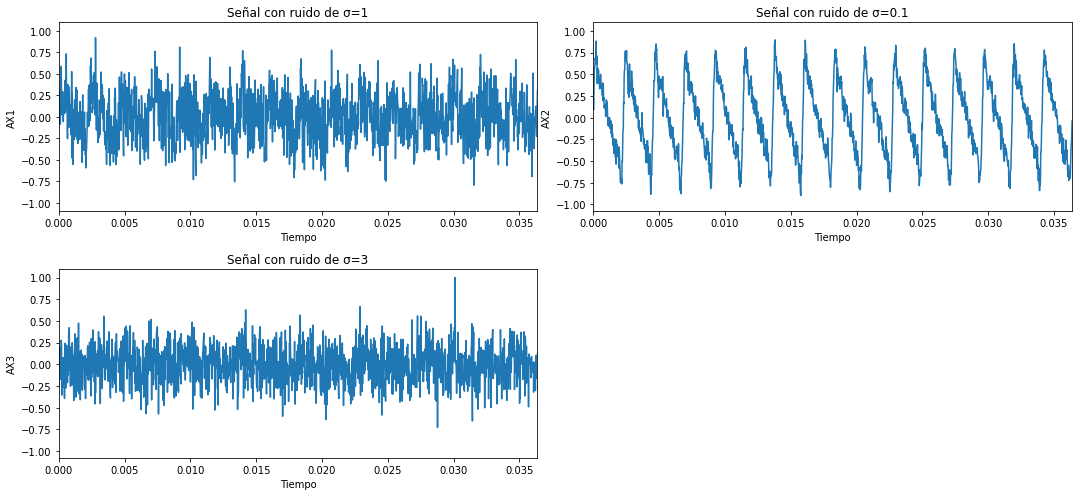

In [99]:
plt.figure(figsize=(15,7))
plt.subplot(2,2,1)
plt.plot(t, AX1)
plt.title('Señal con ruido de σ=1')
plt.xlabel("Tiempo")
plt.ylabel("AX1")
plt.xlim(0, 16/f0)


plt.subplot(2,2,2)
plt.plot(t, AX2)
plt.title('Señal con ruido de σ=0.1')
plt.xlabel("Tiempo")
plt.ylabel("AX2")
plt.xlim(0, 16/f0)


plt.subplot(2,2,3)
plt.plot(t, AX3)
plt.title('Señal con ruido de σ=3')
plt.xlabel("Tiempo")
plt.ylabel("AX3")
plt.xlim(0, 16/f0)
plt.tight_layout()
plt.show()

Defino formula que calcula relacion señal ruido


In [100]:
def Señal_Ruido(A,sigma,f_A):
    SNR = np.round((np.amax(A)-np.mean(A))/sigma,2)
    return SNR

SNR1 = Señal_Ruido(AX1,sigma1,fs/f0)
SNR2 = Señal_Ruido(AX2,sigma2,fs/f0)
SNR3 = Señal_Ruido(AX3,sigma3,fs/f0)



Agregandole a cada señal un componente de continua


In [101]:
DCcomps = [-10, 10, 1000]



Sumando el componente de continua a cada señal


In [102]:
AX1_C1 = AX1 + DCcomps[0]
AX2_C1 = AX2 + DCcomps[0]
AX3_C1 = AX3 + DCcomps[0]

AX1_C2 = AX1 + DCcomps[1]
AX2_C2 = AX2 + DCcomps[1]
AX3_C2 = AX3 + DCcomps[1]

AX1_C3 = AX1 + DCcomps[2]
AX2_C3 = AX2 + DCcomps[2]
AX3_C3 = AX3 + DCcomps[2]



Calculando SNR a cada señal con componente de continua


In [103]:
SNR4 = Señal_Ruido(AX1_C1,sigma1,fs/f0)
SNR5 = Señal_Ruido(AX2_C1,sigma2,fs/f0)
SNR6 = Señal_Ruido(AX3_C1,sigma3,fs/f0)

SNR7 = Señal_Ruido(AX1_C2,sigma1,fs/f0)
SNR8 = Señal_Ruido(AX2_C2,sigma2,fs/f0)
SNR9 = Señal_Ruido(AX3_C2,sigma3,fs/f0)

SNR10 = Señal_Ruido(AX1_C3,sigma1,fs/f0)
SNR11 = Señal_Ruido(AX2_C3,sigma2,fs/f0)
SNR12 = Señal_Ruido(AX3_C3,sigma3,fs/f0)

DC_SNR_layout = go.Layout(
    title='Relaciones Señal-Ruido para distintas desviaciones estándar',
    title_x=0.5,
    margin=go.layout.Margin(
        autoexpand=True
    )
)

fig = go.Figure(data=[go.Table(header=dict(values=['Señal con ruido', 'Sigma', 'SNR', 'SNR con DC=-10', 'SNR con DC=10', 'SNR con DC=1000'],align='center'),
                cells=dict(values=[["Señal 1", "Señal 2", "Señal 3"], [sigma1, sigma2, sigma3] , [SNR1, SNR2, SNR3], [SNR4, SNR5, SNR6], [SNR7, SNR8, SNR9], [SNR10, SNR11, SNR12]],align='center'))
                ],
                layout=DC_SNR_layout)
fig.show()



A medida que el desvio estandar es menor, la relacion señal ruido aumenta, este resultado es coherente con la formula planteada.
El SNR no se modifica con la adición de una componente de continua.

## Ejercicio 4



Se define la función para calcular el promedio en ensamble.



In [104]:
def promedio_ensamble(N):
    # Inicializo Array
    randNoiseSignals = []    

    # Creo las señales y las guardo en el array
    for i in range(N):
        A_randNoise = A + np.random.normal(0, 3, len(t))
        randNoiseSignals.append(A_randNoise)

    # Inicializo un nuevo array que será el promedio, y transpongo el array de señales con ruido para poder sumar los valores para el promedio
    averageA_RN = []
    randNoiseSignals_T = np.array(randNoiseSignals).transpose()
    for i in range(len(randNoiseSignals[0])):
        averageA_RN.append((1/10) * np.sum(randNoiseSignals_T[i]))

    # Mido SNR
    SNR_average = Señal_Ruido(averageA_RN,3,fs/f0)

    # Normalizo
    Amax = np.amax(averageA_RN)
    averageA_RN = averageA_RN / Amax

    return randNoiseSignals, averageA_RN, SNR_average



Se utiliza la función para 10, 100 y 1000 señales.



In [105]:
randNoiseSignals10, averageA_RN10, SNR_average10 = promedio_ensamble(10)
randNoiseSignals100, averageA_RN100, SNR_average100 = promedio_ensamble(100)
randNoiseSignals1000, averageA_RN1000, SNR_average1000 = promedio_ensamble(1000)

Se grafica.



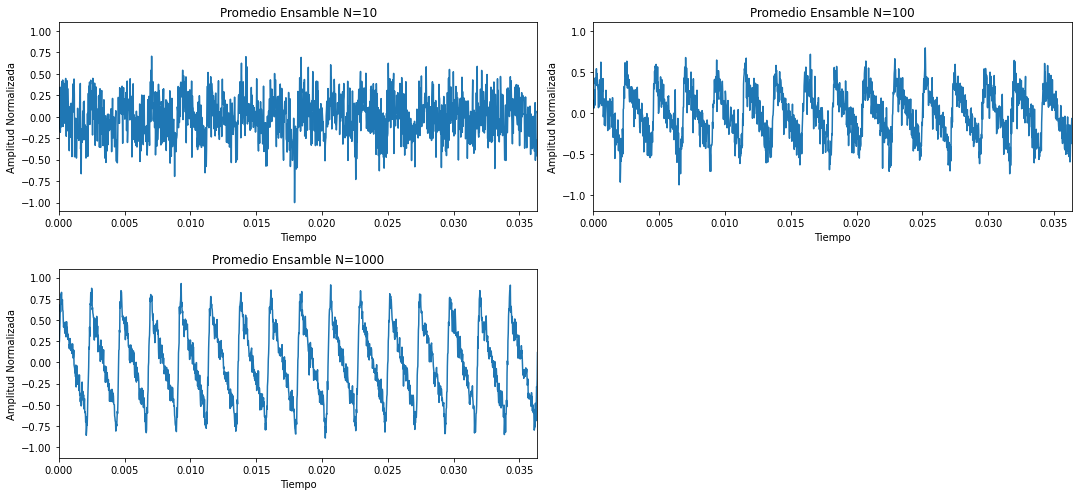

In [106]:
plt.figure(figsize=(15,7))
plt.subplot(2,2,1)
plt.plot(t, averageA_RN10)
plt.title('Promedio Ensamble N=10')
plt.xlabel("Tiempo")
plt.ylabel("Amplitud Normalizada")
plt.xlim(0, 16/f0)


plt.subplot(2,2,2)
plt.plot(t, averageA_RN100)
plt.title('Promedio Ensamble N=100')
plt.xlabel("Tiempo")
plt.ylabel("Amplitud Normalizada")
plt.xlim(0, 16/f0)


plt.subplot(2,2,3)
plt.plot(t, averageA_RN1000)
plt.title('Promedio Ensamble N=1000')
plt.xlabel("Tiempo")
plt.ylabel("Amplitud Normalizada")
plt.xlim(0, 16/f0)
plt.tight_layout()
plt.show()

Se genera tabla de SNRs.

In [107]:
DC_SNR_layout = go.Layout(
    title='SNR para Promedio Ensamble',
    title_x=0.5,
    margin=go.layout.Margin(
        autoexpand=True
    )
)

fig = go.Figure(data=[go.Table(header=dict(values=['Cantidad de señales de ruido', 'SNR promedio', 'SNR ejercicio 3'],align='center'),
                cells=dict(values=[["10", "100", "1000"], [SNR_average10, SNR_average100, SNR_average1000], [SNR1, SNR2, SNR3]],align='center'))
                ],
                layout=DC_SNR_layout)
fig.show()

Se observa que para mayor cantidad de señales, mayor será el SNR del promedio.